# Nonlinear Poisson equation 

$$-div(q(u)*\Delta(u)) = 0,$$
$$u = 0\text{ at }x=0, u=1\text{ at }x=1$$
$$q(u) = (1+u)^m$$

Solution method: Newton method

Newton iteration is a more sophisticated method for solving nonlinear equations and systems. It is based on linearizing the original problem around an initial guess and then iteratively improving the solution by solving linear approximations of the problem.

The Newton iteration can be written in the form:

$$x_{n+1} = x_n - J^{-1}(x_n) * F(x_n)$$

where $x_{n+1}$ is the updated solution at the (n+1)th iteration, $x_n$ is the solution at the nth iteration, $J^{-1}(x_n)$ is the inverse Jacobian matrix of the problem evaluated at $x_n$, and $F(x_n)$ is the residual vector of the problem evaluated at $x_n$.

The Newton method is known for its quadratic convergence, which means that the number of correct digits in the solution roughly doubles with each iteration, making it faster than Picard iteration for problems where it converges. However, Newton's method may not converge if the initial guess is far from the true solution, or if the Jacobian matrix is ill-conditioned or singular at the current solution.

In [101]:
from dolfin import *
import numpy
%matplotlib inline

mesh = IntervalMesh(40,0,1)
V = FunctionSpace(mesh, 'Lagrange', 1)

In [102]:
# Define boundary conditions

tol = 1E-14


left_boundary = CompiledSubDomain("on_boundary && near(x[0],0)")
right_boundary = CompiledSubDomain("on_boundary && near(x[0],1)")


bc_0 = DirichletBC(V, Constant(0.0), left_boundary)
bc_1 = DirichletBC(V, Constant(1.0), right_boundary)
bcs = [bc_0, bc_1]

In [103]:
m = 5


def q(u):
    return (1+u)**m


def Dq(u):
    return m*(1+u)**(m-1)

Newtons method require the evaluation of Jacobian. In this notebook we use manual differentiation for the evaluation of Jacobian.

Manual differentiation involves calculating derivatives by hand, which can be error-prone and time-consuming for complex functions.

$$F=q(u)\nabla u \cdot \nabla v\ \mathrm{d}x$$
$$J = q(u)\nabla \delta u \cdot \nabla v\ \mathrm{d}x + q'(u)\delta u\nabla u \cdot \nabla v\ \mathrm{d}x$$

Go to this link for derivation
https://home.simula.no/~hpl/homepage/fenics-tutorial/release-1.0/webm/nonlinear.html#a-newton-method-at-the-pde-level

In [104]:
# Define variational problem
v = TestFunction(V)
du = TrialFunction(V)
u = Function(V)  # most recently computed solution
F = inner(q(u)*nabla_grad(u), nabla_grad(v))*dx

J = inner(q(u)*nabla_grad(du), nabla_grad(v))*dx + \
    inner(Dq(u)*du*nabla_grad(u), nabla_grad(v))*dx

(6, True)

In [ ]:

# Compute solution
problem = NonlinearVariationalProblem(F, u, bcs, J)
solver = NonlinearVariationalSolver(problem)

prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-5
prm['newton_solver']['relative_tolerance'] = 1E-5
prm['newton_solver']['maximum_iterations'] = 25

solver.solve()

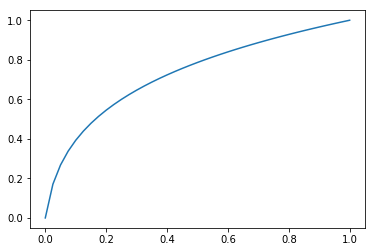

In [105]:
plot(u)

In [114]:
# Find max error
u_exact = Expression(
    'pow((pow(2, m+1)-1)*x[0] + 1, 1.0/(m+1)) - 1', m=m, degree=1)
u_e = interpolate(u_exact, V)
diff = numpy.abs(u_e.vector()[:] - u.vector()[:]).max()
print('Max error:{0:5.3e}'.format(diff))

Max error:1.559e-06
